In [1]:
import numpy as np
import tensorflow as tf

from tensorflow import keras
from scipy.io import loadmat, savemat

from tensorflow.keras import layers

from sklearn.model_selection import KFold
from sklearn.metrics import label_ranking_average_precision_score as avgprec, coverage_error, label_ranking_loss

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
#     logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

In [3]:
Y_4802 = loadmat('Y_4802.mat')['Y_4802']

In [4]:
X_4802_feature = loadmat('feature_4802.mat')

In [5]:
X_4802_feature.keys()

dict_keys(['__header__', '__version__', '__globals__', 'ppab', 'ppdwt', 'pppse', 'pssmab', 'pssmdwt', 'pssmpse', 'label'])

In [6]:
model_list = []
input_list = []
for fname in ['ppab', 'ppdwt', 'pppse', 'pssmab', 'pssmdwt', 'pssmpse']:
    fdata = X_4802_feature[fname]
    input_list.append(fdata)
    input_shape = fdata.shape
    ix = keras.Input(shape=input_shape[1:], dtype = "float32")
    
    x = layers.Conv2D(256, (4,3), activation='relu')(ix)
    x = layers.Conv2D(128, 3, activation='relu',)(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu',)(x)
    #x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(32, 3, activation='relu',)(x)
    outputs = layers.Flatten()(x)
    #outputs = layers.Dense(37, activation='sigmoid')(x)
    model = keras.Model(ix, outputs)
    model_list.append(model)
    
x = layers.concatenate([m.output for m in model_list])
x = layers.Dense(37, activation='sigmoid')(x)
model = keras.Model(inputs=[m.input for m in model_list], outputs = x)
model.summary()

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 38, 30, 2)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 57, 52, 2)]  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 31, 57, 2)]  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 20, 20, 2)]  0                                            
______________________________________________________________________________________

In [7]:
model.compile("adam", "binary_crossentropy", metrics=["binary_accuracy"])
model.fit(input_list, Y_4802, batch_size=8, epochs=5)

Epoch 1/5
601/601 [==============================] - 24s 41ms/step - loss: 0.1335 - binary_accuracy: 0.9645
Epoch 2/5
601/601 [==============================] - 19s 32ms/step - loss: 0.0964 - binary_accuracy: 0.9675
Epoch 3/5
601/601 [==============================] - 20s 33ms/step - loss: 0.0923 - binary_accuracy: 0.9682
Epoch 4/5
601/601 [==============================] - 20s 33ms/step - loss: 0.0891 - binary_accuracy: 0.9688
Epoch 5/5
601/601 [==============================] - 20s 33ms/step - loss: 0.0874 - binary_accuracy: 0.9694


In [5]:
pssmpse = X_4802_feature['pssmpse']

In [6]:
input_shape = pssmpse.shape
pssm = keras.Input(shape=input_shape[1:], dtype = "float32")

x = layers.Conv2D(256, (4,3), activation='relu')(pssm)
x = layers.Conv2D(128, 3, activation='relu',)(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, activation='relu',)(x)
#x = layers.MaxPooling2D()(x)
x = layers.Conv2D(32, 3, activation='relu',)(x)
x = layers.Flatten()(x)
outputs = layers.Dense(37, activation='sigmoid')(x)
model = keras.Model(pssm, outputs)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 31, 20, 2)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 18, 256)       6400      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 16, 128)       295040    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 8, 128)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 6, 64)         73792     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 4, 32)          18464     
_________________________________________________________________
flatten (Flatten)            (None, 1152)             

In [7]:
kf = KFold(5)
ap_list = []
rl_list = []
ce_list = []

#with tf.device("cpu:0"):
for train_index, test_index in kf.split(pssmpse):
    train_x = pssmpse[train_index]
    train_y = Y_4802[train_index]

    model.compile("adam", "binary_crossentropy", metrics=["binary_accuracy"])
    model.fit(train_x, train_y, batch_size=8, epochs=50)
    
    test_x = pssmpse[test_index]
    test_y = Y_4802[test_index]
    
    pred_y = model.predict(test_x)
    ap_score = avgprec(test_y, pred_y)
    ap_list.append(ap_score)
    rl_list.append(label_ranking_loss(test_y, pred_y))
    ce_list.append(coverage_error(test_y, pred_y) - 1)
    
print('the ap score is:', ap_list)
print('average is:', sum(ap_list)/len(ap_list))

print('the rl score is:', rl_list)
print('average is:', sum(rl_list)/len(rl_list))

print('the ce score is:', ce_list)
print('average is:', sum(ce_list)/len(ce_list))

Epoch 1/50
481/481 [==============================] - 4s 9ms/step - loss: 0.0998 - binary_accuracy: 0.9671
Epoch 2/50
481/481 [==============================] - 4s 8ms/step - loss: 0.0895 - binary_accuracy: 0.9699
Epoch 3/50
481/481 [==============================] - 4s 8ms/step - loss: 0.0840 - binary_accuracy: 0.9703
Epoch 4/50
481/481 [==============================] - 4s 8ms/step - loss: 0.0816 - binary_accuracy: 0.9705
Epoch 5/50
481/481 [==============================] - 4s 8ms/step - loss: 0.0801 - binary_accuracy: 0.9708
Epoch 6/50
481/481 [==============================] - 4s 8ms/step - loss: 0.0785 - binary_accuracy: 0.9713
Epoch 7/50
481/481 [==============================] - 4s 9ms/step - loss: 0.0775 - binary_accuracy: 0.9716
Epoch 8/50
481/481 [==============================] - 4s 9ms/step - loss: 0.0766 - binary_accuracy: 0.9718
Epoch 9/50
481/481 [==============================] - 4s 9ms/step - loss: 0.0760 - binary_accuracy: 0.9719
Epoch 10/50
481/481 [================

In [42]:
tmp = np.array([1,2,3,4,5,6])

In [43]:
tmp = tmp.reshape((2,3))

In [45]:
str(tmp)

'[[1 2 3]\n [4 5 6]]'

In [35]:
'abc {}'.format(np.array([1,2,3]))

'abc [1 2 3]'

In [41]:
tmp[[0,1]][:, [0,1]]

array([[1, 2],
       [4, 5]])

In [38]:
tmp 

array([[1, 2, 3],
       [4, 5, 6]])

In [26]:
tmp.flatten()

array([1, 4])

In [28]:
tmp

array([1, 2, 3, 4, 5, 6])

In [32]:
np.expand_dims(tmp, axis = 1).shape

(6, 1)

In [46]:
from scipy.io import loadmat, savemat

In [47]:
sequence = loadmat('dataset_4802.mat')['Sequence']

In [62]:
count = 0
for i in sequence:
    if len(i[0][0]) < 100:
        count += 1

In [63]:
count

164

In [64]:
sequence[0][0][0]

'MDEQEALNSIMNDLVALQMNRRHRMPGYETMKNKDTGHSNRQKKHNSSSSALLNSPTVTTSSCAGASEKKKFLSDVRIKFEHNGERRIIAFSRPVKYEDVEHKVTTVFGQPLDLHYMNNELSILLKNQDDLDKAIDILDRSSSMKSLRILLLSQDRNHNSSSPHSGVSRQVRIKASQSAGDINTIYQPPEPRSRHLSVSSQNPGRSSPPPGYVPERQQHIARQGSYTSINSEGEFIPETSEQCMLDPLSSAENSLSGSCQSLDRSADSPSFRKSRMSRAQSFPDNRQEYSDRETQLYDKGVKGGTYPRRYHVSVHHKDYSDGRRTFPRIRRHQGNLFTLVPSSRSLSTNGENMGLAVQYLDPRGRLRSADSENALSVQERNVPTKSPSAPINWRRGKLLGQGAFGRVYLCYDVDTGRELASKQVQFDPDSPETSKEVSALECEIQLLKNLQHERIVQYYGCLRDRAEKTLTIFMEYMPGGSVKDQLKAYGALTESVTRKYTRQILEGMSYLHSNMIVHRDIKGANILRDSAGNVKLGDFGASKRLQTICMSGTGMRSVTGTPYWMSPEVISGEGYGRKADVWSLGCTVVEMLTEKPPWAEYEAMAAIFKIATQPTNPQLPSHISEHGRDFLRRIFVEARQRPSAEELLTHHFAQLMY'

In [200]:
Y_4802 = loadmat('Y_4802.mat')['Y_4802']

In [72]:
Y_4802

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [67]:
sequence = loadmat('dataset_4802.mat')['Sequence']

In [152]:
uniform_one_encode = []
uniform_label = []
for sq, lb in zip(sequence, Y_4802):
    seq = sq[0][0]
    if len(seq) > 100:
        result = p_split(seq, 100)
    else:
        result = [seq]
    for r in result:
        uniform_one_encode.append(preprocess(r, 100))
        uniform_label.append(lb)
#     print(preprocess(sq[0][0][0:95], 100), lb)
#     t = preprocess(sq[0][0][0:95], 100)

In [153]:
np.array(uniform_one_encode).shape

(55950, 100, 22)

In [154]:
np.array(uniform_label).shape

(55950, 37)

In [ ]:
uniform_one_encode

In [133]:
def p_split(p_seq, l):
    result = []
    s = 0
    e = s + l
    while (s + l//2) < len(p_seq):
        t = p_seq[s:e]
        if len(t) < l:
            t = p_seq[-l:]
        s = s + l//2
        e = s + l
        result.append(t)
    return result

In [75]:
np.arange(2, 10)

array([2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
uniform_one_encode = []
for s in sequence:
    p_seq = list(s[0][0])
    seq_num = np.array([amino_code[x] for x in p_seq])
    tmp = np.zeros((seq_num.size, 22))
    s = (100 - len(seq_num.size))//2
    e = s + seq_num.size
    tmp[np.arange(s, e), seq_num] = 1
    extend_one_encode.append(tmp)

In [89]:
def preprocess(p_seq, l):
    seq_num = np.array([amino_code[x] for x in p_seq])
    tmp = np.zeros((l, 22))
    s = (100 - seq_num.size)//2
    e = s + seq_num.size
    tmp[np.arange(s, e), seq_num] = 1
    return tmp

In [78]:
amino_code = {'A':0, 'C':1, 'D':2, 'E':3, 'F':4, 'G':5, 'H':6,
             'I':7, 'K':8, 'L':9, 'M':10, 'N':11, 'P':12, 
             'Q':13, 'R':14, 'S':15, 'T':16, 'U':17, 'V':18,
             'W':19, 'X':20, 'Y':21 }

In [176]:
import numpy as np
from sklearn.model_selection import KFold
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4])
kf = KFold(n_splits=2, shuffle = False)
kf.get_n_splits(X)

print(kf)

for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

KFold(n_splits=2, random_state=None, shuffle=False)
TRAIN: [2 3] TEST: [0 1]
TRAIN: [0 1] TEST: [2 3]


In [25]:
oridata = loadmat('dataset_4802.mat')

In [26]:
oridata.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Header', 'Sequence', 'Y_4802', 'Y_4802_label'])

In [29]:
oridata['Sequence']

array([[array(['MDEQEALNSIMNDLVALQMNRRHRMPGYETMKNKDTGHSNRQKKHNSSSSALLNSPTVTTSSCAGASEKKKFLSDVRIKFEHNGERRIIAFSRPVKYEDVEHKVTTVFGQPLDLHYMNNELSILLKNQDDLDKAIDILDRSSSMKSLRILLLSQDRNHNSSSPHSGVSRQVRIKASQSAGDINTIYQPPEPRSRHLSVSSQNPGRSSPPPGYVPERQQHIARQGSYTSINSEGEFIPETSEQCMLDPLSSAENSLSGSCQSLDRSADSPSFRKSRMSRAQSFPDNRQEYSDRETQLYDKGVKGGTYPRRYHVSVHHKDYSDGRRTFPRIRRHQGNLFTLVPSSRSLSTNGENMGLAVQYLDPRGRLRSADSENALSVQERNVPTKSPSAPINWRRGKLLGQGAFGRVYLCYDVDTGRELASKQVQFDPDSPETSKEVSALECEIQLLKNLQHERIVQYYGCLRDRAEKTLTIFMEYMPGGSVKDQLKAYGALTESVTRKYTRQILEGMSYLHSNMIVHRDIKGANILRDSAGNVKLGDFGASKRLQTICMSGTGMRSVTGTPYWMSPEVISGEGYGRKADVWSLGCTVVEMLTEKPPWAEYEAMAAIFKIATQPTNPQLPSHISEHGRDFLRRIFVEARQRPSAEELLTHHFAQLMY'],
      dtype='<U657')],
       [array(['MDTEGFGELLQQAEQLAAETEGISELPHVERNLQEIQQAGERLRSRTLTRTSQETADVKASVLLGSRGLDISHISQRLESLSAATTFEPLEPVKDTDIQGFLKNEKDNALLSAIEESRKRTFGMAEEYHRESMLVEWEQVKQRILHTLLASGEDALDFTQESEPSYISDVGPPGRSSLDNIEMAYARQIYIYNEKIVNGHLQPNLVDLCASVAELDDKSISDMWTMVKQMTDVLLTPATDALKNRSSVEVRMEFVRQALAYLEQSYKNYTLVTVFGNLHQAQLG

In [6]:
X_4802_feature = loadmat('feature_4802.mat')

In [12]:
X_4802_feature.keys()

dict_keys(['__header__', '__version__', '__globals__', 'ppab', 'ppdwt', 'pppse', 'pssmab', 'pssmdwt', 'pssmpse', 'label'])

In [18]:
np.amax(X_4802_feature['pppse'])

1.0

In [19]:
np.amax(X_4802_feature['ppdwt'])

12510.368390131456

In [20]:
tmp = X_4802_feature['ppdwt']
tmp = (tmp - np.amin(tmp))/(np.amax(tmp) - np.amin(tmp))

In [24]:
np.amax(tmp * 250)

250.0

In [46]:
d4 = loadmat('dataset_3106.mat')

In [48]:
d4.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Y_3106', 'label_name', 'protein_list', 'sequence_3106'])

In [89]:
d4['sequence_3106']

array([[array(['MFRRKLTALDYHNPAGFNCKDETEFRNFIVWLEDQKIRHYKIEDRGNLRNIHSSDWPKFFEKYLRDVNCPFKIQDRQEAIDWLLGLAVRLEYGDNAEKYKDLVPDNSKTADNATKNAEPLINLDVNNPDFKAGVMALANLLQIQRHDDYLVMLKAIRILVQERLTQDAVAKANQTKEGLPVALDKHILGFDTGDAVLNEAAQILRLLHIEELRELQTKINEAIVAVQAIIADPKTDHRLGKVGR'],
      dtype='<U244')],
       [array(['MIDSVKLRRDSAADFFSHYEYLCALQNSVPLPAVRACLREGVLDFNADRLRGVDWAPLLSTLKINKDLPLVSIKSFFQPWLGDTGSDMNKFCRSRVPAIRYKDVTFQLCKALKGCLSISSVLKNLELNGLILRERDLTILAKGLNKSASLVHLSLANCPIGDGGLEIICQGIKSSITLKTVNFTGCNLTWQGADHMAKILKYQTMRRHEETWAESLRYRRPDLDCMAGLRRITLNCNTLIGDLGACAFADSLSEDLWLRALDLQQCGLTNEGAKALLEALETNTTLVVLDIRKNPLIDHSMMKAVIKKVLQNGRSAKSEYQWITSPSVKEPSKTAKQKRRTIILGSGHKGKATIRIGLATKKPVSSGRKHSLGKEYYAPAPLPPGVSGFLPWRTAERAKRHRGFPLIKTRDICNQLQQPGFPVTVTVESPSSSEVEEVDDSSESVHEVPEKTSIEQEALQEKLEECLKQLKEERVIRLKVDKRVSELEHENAQLRNINFSLSEALHAQSLTNMILDDEGVLGSIENSFQKFHAFLDLLKDAGLGQLATMAGIDQSDFQLLGHPQMTSTVSNPPKEEKKALEDEKPEPKQNALGQMQNIQFQKITGDARIPLPLDSFPVPVSTPEGLGTSSNNLGVPATEQRQESFEGFIARMCSPSPDATSGTGSQRKEEELSRNSRSSSEKKTKTESH'],
    

In [3]:
d4['Y_4802_label'].shape

(37, 1)

In [49]:
label = d4['label_name']

In [50]:
for l in label:
    print(l)

[array(['Centrosome'], dtype='<U10')]
[array(['Cytoplasm'], dtype='<U9')]
[array(['Cytoskeleton'], dtype='<U12')]
[array(['Endosome'], dtype='<U8')]
[array(['Endoplasmic-Reticulum'], dtype='<U21')]
[array(['Extracellular'], dtype='<U13')]
[array(['Golgi-Apparatus'], dtype='<U15')]
[array(['Lysosome'], dtype='<U8')]
[array(['Microsome'], dtype='<U9')]
[array(['Mitochondrion'], dtype='<U13')]
[array(['Nucleus'], dtype='<U7')]
[array(['Peroxisome'], dtype='<U10')]
[array(['Plasma-Membrane'], dtype='<U15')]
[array(['Synapse'], dtype='<U7')]


In [51]:
l4 = d4['Y_3106']

In [7]:
l4[[1,2]] 

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]], dtype=uint8)

0

In [62]:
res = np.zeros((37, 37))
for i in range(37):
    for j in range(i + 1, 37):
        # print(i, j)
        res[i, j] = sum(l4[l4[:, i] == 1][:, j] == 1)

In [74]:
for r in res:
    print(' '.join([str(int(x)) for x in r]))

0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 15 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 28 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0
0 0 0 0 23 0 6 0 0 1 1 0 2 0 0 0 0 0 0 0 0 0 0 0 1 0 0 12 0 0 0 0 0 0 0 0 0
0 0 0 0 0 3 16 0 1 1 17 8 18 0 0 0 0 0 0 1 0 0 2 0 24 0 0 401 0 7 41 0 0 0 2 0 0
0 0 0 0 0 0 0 0 1 0 0 1 11 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 6 0 3 0 0 1 1
0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 1 1 0 0 0 9 0 0 11 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 1 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 41 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 9 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 2 3 20 2 0 0 0 0 1 1 0 0 0 0 0 2 0 2 0 0 10 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 2 28 0 0 0 0 8 0 10 0 1 11 0 6 0 0 13 0 1 56 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 12 0 0 0 0 0 0 7 0 0 0 0 1 0 0 3 0 0 31 0 4 0 1 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 5 3 11 0 0 0 2 7 1 0 0 0 0 0 5 0 0 29 0 1 0 1 0 0
0 0 0 0 0 0 0

In [8]:
res = np.zeros((37, 37))
for i in range(37):
    for j in range(37):
        # print(i, j)
        res[i, j] = sum(l4[l4[:, i] == 1][:, j] == 1)

In [9]:
for r in res:
    print(' '.join([str(int(x)) for x in r]))

16 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 15 0 0 0 0 0 0
0 29 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 28 0 0 0 0 0 0
0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0
0 0 0 81 23 0 6 0 0 1 1 0 2 0 0 0 0 0 0 0 0 0 0 0 1 0 0 12 0 0 0 0 0 0 0 0 0
1 0 0 23 1050 3 16 0 1 1 17 8 18 0 0 0 0 0 0 1 0 0 2 0 24 0 0 401 0 7 41 0 0 0 2 0 0
0 0 0 0 3 46 0 0 1 0 0 1 11 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 6 0 3 0 0 1 1
0 0 0 6 16 0 89 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 1 1 0 0 0 9 0 0 11 0 0 0 0 0 0
0 0 0 0 0 0 0 4 0 1 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 1 1 0 0 52 0 41 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 9 0 0 0 0 0 0
0 0 0 1 1 0 0 1 0 120 2 3 20 2 0 0 0 0 1 1 0 0 0 0 0 2 0 2 0 0 10 0 0 0 0 0 0
0 0 0 1 17 0 0 0 41 2 342 2 28 0 0 0 0 8 0 10 0 1 11 0 6 0 0 13 0 1 56 0 0 0 0 0 0
0 0 0 0 8 1 0 0 0 3 2 487 12 0 0 0 0 0 0 7 0 0 0 0 1 0 0 3 0 0 31 0 4 0 1 0 0
0 1 0 2 18 11 3 3 0 20 28 12 272 5 3 11 0 0 0 2 7 1 0 0 0 0 0 5 0 0 29

In [53]:
res = np.zeros((37, 37))
for i in range(14):
    tmp = l4[l4[:, i] == 1]
    print(tmp.shape)
    count = 0
    for t in tmp:
        if sum(t) == 1:
            count += 1
    print(label[i][0][0], count)

(77, 14)
Centrosome 47
(817, 14)
Cytoplasm 457
(79, 14)
Cytoskeleton 45
(24, 14)
Endosome 13
(229, 14)
Endoplasmic-Reticulum 155
(385, 14)
Extracellular 347
(161, 14)
Golgi-Apparatus 96
(77, 14)
Lysosome 59
(24, 14)
Microsome 11
(364, 14)
Mitochondrion 321
(1021, 14)
Nucleus 718
(47, 14)
Peroxisome 35
(354, 14)
Plasma-Membrane 267
(22, 14)
Synapse 9


In [11]:
res = np.zeros((37, 37))
for i in range(37):
    tmp = sum(l4[l4[:, i] == 1][:, i] == 1)
    for j in range(37):
        if i == j:
            continue
        res[i, j] = sum(l4[l4[:, i] == 1][:, j] == 1)
    print(label[i][0][0], tmp - sum(res[i,:]))

Apical Plasma Membrane 0.0
Basolateral Plasma Membrane 0.0
Cellular Component Unknown 0.0
Centrosome 35.0
Cytoplasm 484.0
Cytoplasmic Vesicles 17.0
Cytoskeleton 42.0
ERGIC 0.0
Early Endosomes 0.0
Endoplasmic Reticulum 74.0
Endosomes 145.0
Extracellular 414.0
Golgi Apparatus 109.0
Golgi Cis Cisterna 0.0
Golgi Trans Cisterna 0.0
Golgi Trans Face 0.0
Inner Mitochondrial Membrane 0.0
Late Endosomes 0.0
Lipid Particles 0.0
Lysosomes 85.0
Medial-Golgi 0.0
Melanosome 4.0
Microtubule 8.0
Microtubule Organizing Center 0.0
Mitochondria 344.0
Nuclear Envelope 1.0
Nucleolus 0.0
Nucleus 922.0
Outer Mitochondrial Membrane 0.0
Peroxisome 56.0
Plasma Membrane 547.0
Sarcolemma 0.0
Secretory Granule 1.0
Secretory Vesicles 2.0
Synaptic Vesicles 14.0
Tight Junction 0.0
Transport Vesicle 0.0


In [ ]:
res = np.zeros((37, 37))
for i in range(37):
    tmp = l4[l4[:, i] == 1]
    print(tmp.shape)
    count = 0
    for t in tmp:
        if sum(t) > 2:
            print(t)
            count += 1
    print(label[i][0][0], count)
    

In [29]:
data4 = np.delete(l4, [18,23,28,31], 1)

In [ ]:
for i in range(33):
    tmp = data4[data4[:, i] == 1]
    print(tmp.shape)
    count = 0
    for t in tmp:
        if sum(t) > 2:
            print(t)
            count += 1
    print(label[i][0][0], count)

In [32]:
tmp = data4[data4[:, 3] == 1]

In [41]:
count = 0
for t in tmp:
    if sum(t) == 1:
        count += 1
print(count)

44


In [77]:
d3 = loadmat('dataset_3106.mat')

In [78]:
d3.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Y_3106', 'label_name', 'protein_list', 'sequence_3106'])

In [79]:
d3['label_name']

array([[array(['Centrosome'], dtype='<U10')],
       [array(['Cytoplasm'], dtype='<U9')],
       [array(['Cytoskeleton'], dtype='<U12')],
       [array(['Endosome'], dtype='<U8')],
       [array(['Endoplasmic-Reticulum'], dtype='<U21')],
       [array(['Extracellular'], dtype='<U13')],
       [array(['Golgi-Apparatus'], dtype='<U15')],
       [array(['Lysosome'], dtype='<U8')],
       [array(['Microsome'], dtype='<U9')],
       [array(['Mitochondrion'], dtype='<U13')],
       [array(['Nucleus'], dtype='<U7')],
       [array(['Peroxisome'], dtype='<U10')],
       [array(['Plasma-Membrane'], dtype='<U15')],
       [array(['Synapse'], dtype='<U7')]], dtype=object)

In [80]:
l3 = d3['Y_3106']

In [81]:
res = np.zeros((14, 14))
for i in range(14):
    for j in range(i + 1, 14):
        # print(i, j)
        res[i, j] = sum(l3[l3[:, i] == 1][:, j] == 1)

In [83]:
for r in res:
    print(' '.join([str(int(x)) for x in r]))

0 15 7 1 1 0 2 0 0 1 12 0 0 0
0 0 12 2 13 8 12 2 1 24 263 8 24 2
0 0 0 0 0 0 3 0 0 0 7 0 9 0
0 0 0 0 2 0 4 3 0 0 1 0 1 0
0 0 0 0 0 3 28 2 11 7 14 1 10 0
0 0 0 0 0 0 7 5 0 1 3 0 16 1
0 0 0 0 0 0 0 1 0 0 4 0 20 1
0 0 0 0 0 0 0 0 0 0 2 0 4 0
0 0 0 0 0 0 0 0 0 2 1 0 1 0
0 0 0 0 0 0 0 0 0 0 15 4 1 0
0 0 0 0 0 0 0 0 0 0 0 0 11 1
0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 10
0 0 0 0 0 0 0 0 0 0 0 0 0 0


In [104]:
from Bio import SeqIO
fafile = SeqIO.parse('pssm/dataset_3106/ff/1.fasta', 'fasta')

In [105]:
t = list(fafile)

In [106]:
str(t[0].seq)

'MIDSVKLRRDSAADFFSHYEYLCALQNSVPLPAVRACLREGVLDFNADRLRGVDWAPLLSTLKINKDLPLVSIKSFFQPWLGDTGSDMNKFCRSRVPAIRYKDVTFQLCKALKGCLSISSVLKNLELNGLILRERDLTILAKGLNKSASLVHLSLANCPIGDGGLEIICQGIKSSITLKTVNFTGCNLTWQGADHMAKILKYQTMRRHEETWAESLRYRRPDLDCMAGLRRITLNCNTLIGDLGACAFADSLSEDLWLRALDLQQCGLTNEGAKALLEALETNTTLVVLDIRKNPLIDHSMMKAVIKKVLQNGRSAKSEYQWITSPSVKEPSKTAKQKRRTIILGSGHKGKATIRIGLATKKPVSSGRKHSLGKEYYAPAPLPPGVSGFLPWRTAERAKRHRGFPLIKTRDICNQLQQPGFPVTVTVESPSSSEVEEVDDSSESVHEVPEKTSIEQEALQEKLEECLKQLKEERVIRLKVDKRVSELEHENAQLRNINFSLSEALHAQSLTNMILDDEGVLGSIENSFQKFHAFLDLLKDAGLGQLATMAGIDQSDFQLLGHPQMTSTVSNPPKEEKKALEDEKPEPKQNALGQMQNIQFQKITGDARIPLPLDSFPVPVSTPEGLGTSSNNLGVPATEQRQESFEGFIARMCSPSPDATSGTGSQRKEEELSRNSRSSSEKKTKTESH'

In [103]:
res = [str(t[0].seq)]

In [107]:
res.append(str(t[0].seq))

In [108]:
res

['MFRRKLTALDYHNPAGFNCKDETEFRNFIVWLEDQKIRHYKIEDRGNLRNIHSSDWPKFFEKYLRDVNCPFKIQDRQEAIDWLLGLAVRLEYGDNAEKYKDLVPDNSKTADNATKNAEPLINLDVNNPDFKAGVMALANLLQIQRHDDYLVMLKAIRILVQERLTQDAVAKANQTKEGLPVALDKHILGFDTGDAVLNEAAQILRLLHIEELRELQTKINEAIVAVQAIIADPKTDHRLGKVGR',
 'MIDSVKLRRDSAADFFSHYEYLCALQNSVPLPAVRACLREGVLDFNADRLRGVDWAPLLSTLKINKDLPLVSIKSFFQPWLGDTGSDMNKFCRSRVPAIRYKDVTFQLCKALKGCLSISSVLKNLELNGLILRERDLTILAKGLNKSASLVHLSLANCPIGDGGLEIICQGIKSSITLKTVNFTGCNLTWQGADHMAKILKYQTMRRHEETWAESLRYRRPDLDCMAGLRRITLNCNTLIGDLGACAFADSLSEDLWLRALDLQQCGLTNEGAKALLEALETNTTLVVLDIRKNPLIDHSMMKAVIKKVLQNGRSAKSEYQWITSPSVKEPSKTAKQKRRTIILGSGHKGKATIRIGLATKKPVSSGRKHSLGKEYYAPAPLPPGVSGFLPWRTAERAKRHRGFPLIKTRDICNQLQQPGFPVTVTVESPSSSEVEEVDDSSESVHEVPEKTSIEQEALQEKLEECLKQLKEERVIRLKVDKRVSELEHENAQLRNINFSLSEALHAQSLTNMILDDEGVLGSIENSFQKFHAFLDLLKDAGLGQLATMAGIDQSDFQLLGHPQMTSTVSNPPKEEKKALEDEKPEPKQNALGQMQNIQFQKITGDARIPLPLDSFPVPVSTPEGLGTSSNNLGVPATEQRQESFEGFIARMCSPSPDATSGTGSQRKEEELSRNSRSSSEKKTKTESH']

In [110]:
np.array(res)[0]

'MFRRKLTALDYHNPAGFNCKDETEFRNFIVWLEDQKIRHYKIEDRGNLRNIHSSDWPKFFEKYLRDVNCPFKIQDRQEAIDWLLGLAVRLEYGDNAEKYKDLVPDNSKTADNATKNAEPLINLDVNNPDFKAGVMALANLLQIQRHDDYLVMLKAIRILVQERLTQDAVAKANQTKEGLPVALDKHILGFDTGDAVLNEAAQILRLLHIEELRELQTKINEAIVAVQAIIADPKTDHRLGKVGR'

In [341]:
res = []
for i in range(3106):
    fafile = SeqIO.parse('pssm/dataset_3106/ff/' + str(i) + '.fasta', 'fasta')
    res.append(str(list(fafile)[0].seq))

In [342]:
res = np.array(res)

In [343]:
pssm_res = []
for i in range(3106):
    tmp = []    
    with open('pssm/dataset_3106/pssm/' + str(i) + '.pssm', 'r') as pfile:
        for line in pfile:
            tmp.append(line.strip().split()[2:])
    tmp = [[float(x) for x in t] for t in tmp[3: (3+len(res[i]))]]
    # print(i)
    if np.array(tmp).shape[1] != 42:
        print(i)
    pssm_res.append(np.array(tmp)) # [3: (3+len(res[i]))]))

In [344]:
pssm_res = np.array(pssm_res)

In [313]:
for tp in pssm_res:
    if tp.shape[1] != 42:
        print(tp.shape)

IndexError: tuple index out of range

In [311]:
pssm_res

array([array([[-1.  , -2.  , -3.  , ...,  0.  ,  0.41,  0.03],
       [-2.  , -2.  ,  1.  , ...,  0.  ,  1.03,  0.04],
       [-1.  , -1.  ,  1.  , ...,  0.  ,  0.74,  0.03],
       ...,
       [-2.  , -1.  , -1.  , ..., 10.  ,  0.1 ,  0.12],
       [-2.  , -3.  ,  0.  , ...,  2.  ,  0.54,  0.26],
       [-4.  , -4.  , -3.  , ...,  0.  ,  1.95,  0.44]]),
       array([[-1.  , -1.  , -2.  , ...,  0.  ,  0.34,  0.  ],
       [-1.  , -1.  ,  0.  , ...,  0.  ,  0.72,  0.03],
       [ 2.  , -2.  , -1.  , ...,  0.  ,  0.18,  0.02],
       ...,
       [-1.  , -1.  , -2.  , ...,  0.  ,  0.24,  0.  ],
       [-1.  , -2.  , -2.  , ...,  0.  ,  0.39,  0.02],
       [-2.  ,  0.  ,  6.  , ...,  0.  ,  0.72,  0.  ]]),
       array([[-1.  , -1.  , -2.  , ...,  0.  ,  0.35,  0.01],
       [-2.  , -2.  ,  1.  , ...,  0.  ,  0.93,  0.  ],
       [-1.  ,  0.  ,  0.  , ...,  0.  ,  0.47,  0.01],
       ...,
       [-1.  , -2.  , -2.  , ...,  0.  ,  2.05,  0.  ],
       [ 0.  ,  3.  ,  0.  , ...,  0.  ,  0

In [310]:
pssm_res[0].shape

(657, 42)

In [279]:
for p in pssm_res:
    if p.shape[1] != 42:
        print(p.shape)

In [280]:
pssm_res

array([array([[-1.00e+00, -2.00e+00, -2.00e+00, ...,  0.00e+00,  3.90e-01,
         2.00e-02],
       [-1.00e+00, -2.00e+00, -1.00e+00, ...,  0.00e+00,  3.60e-01,
         1.00e-02],
       [-2.00e+00,  6.00e+00, -1.00e+00, ...,  0.00e+00,  7.80e-01,
         1.00e-02],
       ...,
       [ 0.00e+00, -3.00e+00, -3.00e+00, ...,  1.00e+02,  3.60e-01,
         1.00e-02],
       [ 0.00e+00, -3.00e+00,  0.00e+00, ...,  0.00e+00,  1.06e+00,
         1.00e-02],
       [-2.00e+00,  6.00e+00, -1.00e+00, ...,  0.00e+00,  7.70e-01,
         1.00e-02]]),
       array([[-1.0e+00, -2.0e+00, -3.0e+00, ...,  0.0e+00,  3.7e-01,  1.0e-02],
       [-1.0e+00, -3.0e+00, -3.0e+00, ...,  2.1e+01,  4.0e-01,  3.0e-02],
       [-2.0e+00,  0.0e+00,  0.0e+00, ...,  0.0e+00,  4.5e-01,  4.0e-02],
       ...,
       [-1.0e+00,  0.0e+00,  0.0e+00, ...,  0.0e+00,  0.0e+00,  0.0e+00],
       [ 1.0e+00, -1.0e+00,  1.0e+00, ...,  0.0e+00,  0.0e+00,  0.0e+00],
       [-2.0e+00,  0.0e+00,  1.0e+00, ...,  0.0e+00,  0.0e+00,

In [172]:
pssm_res[3105].shape[0]

455

In [173]:
from scipy.io import savemat

In [345]:
savemat('dataset_3106_pssm.mat', {'sequence':res, 'pssm':pssm_res})

In [346]:
def preprocess(p_seq, l):
    seq_num = np.array([amino_code[x] for x in p_seq])
    tmp = np.zeros((l, 22))
    s = (100 - seq_num.size)//2
    e = s + seq_num.size
    tmp[np.arange(s, e), seq_num] = 1
    return np.transpose(tmp)

def m_split(p_seq, l):
    result = []
    
    pl = p_seq.shape[0]
    if pl < 100:
        pre = (l-pl) // 2
        suf = l - pl -pre
        
        return [np.concatenate((np.zeros((pre, p_seq.shape[1])),
                       p_seq, np.zeros((suf, p_seq.shape[1]))), axis = 0)]
    s = 0
    e = s + l
    while (s + l//2) < len(p_seq):
        t = p_seq[s:e, :]
        if len(t) < l:
            t = p_seq[-l:, :]
        s = s + l//2
        e = s + l
        result.append(t)
    return result

In [365]:
pssmd = loadmat('dataset_3106_pssm.mat')

In [366]:
pssmd.keys()

dict_keys(['__header__', '__version__', '__globals__', 'sequence', 'pssm'])

In [367]:
pd = pssmd['pssm'][0]

In [368]:
pd.shape

(3106,)

In [369]:
for tp in pd:
    if tp.shape[1] != 42:
        print(tp.shape)

In [352]:
tmp = np.array(m_split(pd[0], 100))

In [353]:
for t in tmp:
    print(t)
    break

[[-1.00e+00 -2.00e+00 -3.00e+00 ...  0.00e+00  4.10e-01  3.00e-02]
 [-2.00e+00 -2.00e+00  1.00e+00 ...  0.00e+00  1.03e+00  4.00e-02]
 [-1.00e+00 -1.00e+00  1.00e+00 ...  0.00e+00  7.40e-01  3.00e-02]
 ...
 [-1.00e+00  1.00e+00 -1.00e+00 ...  1.70e+01  5.10e-01  1.20e-01]
 [-1.00e+00  2.00e+00  2.00e+00 ...  0.00e+00  3.50e-01  7.00e-02]
 [-1.00e+00 -3.00e+00 -3.00e+00 ...  3.50e+01  3.60e-01  7.00e-02]]


In [293]:
tmp[0, :]

array([[-1.00e+00, -2.00e+00, -3.00e+00, ...,  0.00e+00,  4.10e-01,
         3.00e-02],
       [-2.00e+00, -2.00e+00,  1.00e+00, ...,  0.00e+00,  1.03e+00,
         4.00e-02],
       [-1.00e+00, -1.00e+00,  1.00e+00, ...,  0.00e+00,  7.40e-01,
         3.00e-02],
       ...,
       [-1.00e+00,  1.00e+00, -1.00e+00, ...,  1.70e+01,  5.10e-01,
         1.20e-01],
       [-1.00e+00,  2.00e+00,  2.00e+00, ...,  0.00e+00,  3.50e-01,
         7.00e-02],
       [-1.00e+00, -3.00e+00, -3.00e+00, ...,  3.50e+01,  3.60e-01,
         7.00e-02]])

In [294]:
tmp

array([[[-1.00e+00, -2.00e+00, -3.00e+00, ...,  0.00e+00,  4.10e-01,
          3.00e-02],
        [-2.00e+00, -2.00e+00,  1.00e+00, ...,  0.00e+00,  1.03e+00,
          4.00e-02],
        [-1.00e+00, -1.00e+00,  1.00e+00, ...,  0.00e+00,  7.40e-01,
          3.00e-02],
        ...,
        [-1.00e+00,  1.00e+00, -1.00e+00, ...,  1.70e+01,  5.10e-01,
          1.20e-01],
        [-1.00e+00,  2.00e+00,  2.00e+00, ...,  0.00e+00,  3.50e-01,
          7.00e-02],
        [-1.00e+00, -3.00e+00, -3.00e+00, ...,  3.50e+01,  3.60e-01,
          7.00e-02]],

       [[ 1.00e+00, -1.00e+00,  2.00e+00, ...,  1.00e+00,  3.10e-01,
          4.00e-02],
        [-1.00e+00,  0.00e+00, -1.00e+00, ...,  1.00e+00,  8.00e-02,
          2.00e-02],
        [ 1.00e+00, -1.00e+00, -1.00e+00, ...,  1.60e+01,  1.10e-01,
          2.00e-02],
        ...,
        [ 0.00e+00,  2.00e+00, -1.00e+00, ...,  1.00e+00,  4.40e-01,
          1.40e-01],
        [-1.00e+00, -2.00e+00,  0.00e+00, ...,  7.00e+00,  1.00e-01,
   

In [354]:
tmp.shape

(13, 100, 42)

In [296]:
Y_4802

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [370]:
Y_3106 = loadmat('Y_3106.mat')['Y_3106']

In [371]:
pres = []
lres = []
for p, l in zip(pd, Y_4802):
    tmp = np.array(m_split(p, 100))
    for t in tmp:
        pres.append(t)
        lres.append(l)

In [376]:
pres = np.array(pres)

In [393]:
tmp = pres[0]
np.amin(tmp, axis = 0)
(tmp - np.amin(tmp, axis = 0))/(np.amax(tmp, axis = 0) - np.amin(tmp, axis = 0))

array([[0.28571429, 0.11111111, 0.2       , ..., 0.        , 0.13765182,
        0.4       ],
       [0.28571429, 0.11111111, 0.3       , ..., 0.        , 0.12550607,
        0.2       ],
       [0.14285714, 1.        , 0.3       , ..., 0.        , 0.29554656,
        0.2       ],
       ...,
       [0.28571429, 0.44444444, 0.3       , ..., 0.        , 0.10121457,
        0.4       ],
       [0.14285714, 0.11111111, 0.1       , ..., 0.        , 0.28744939,
        0.6       ],
       [0.42857143, 0.55555556, 0.4       , ..., 0.        , 0.13360324,
        0.2       ]])

In [390]:
np.amax(np.amax(pres, axis = 0), axis = 0)

array([  7.  ,   9.  ,   9.  ,   9.  ,  12.  ,   9.  ,   8.  ,   8.  ,
        12.  ,   8.  ,   7.  ,   9.  ,  11.  ,  10.  ,   9.  ,   8.  ,
         8.  ,  13.  ,  11.  ,   8.  , 100.  , 100.  , 100.  , 100.  ,
       100.  , 100.  , 100.  , 100.  , 100.  , 100.  , 100.  , 100.  ,
       100.  , 100.  , 100.  , 100.  , 100.  , 100.  , 100.  , 100.  ,
         5.7 ,   2.13])

In [391]:
np.amin(np.amin(pres, axis = 0), axis = 0)

array([-14.  , -14.  , -15.  , -16.  , -14.  , -14.  , -15.  , -14.  ,
       -14.  , -14.  , -13.  , -15.  , -14.  , -14.  , -15.  , -13.  ,
       -12.  , -15.  , -14.  , -14.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
        -0.04,  -0.03])

In [301]:
pd[0]

array([[-1.  , -2.  , -3.  , ...,  0.  ,  0.41,  0.03],
       [-2.  , -2.  ,  1.  , ...,  0.  ,  1.03,  0.04],
       [-1.  , -1.  ,  1.  , ...,  0.  ,  0.74,  0.03],
       ...,
       [-2.  , -1.  , -1.  , ..., 10.  ,  0.1 ,  0.12],
       [-2.  , -3.  ,  0.  , ...,  2.  ,  0.54,  0.26],
       [-4.  , -4.  , -3.  , ...,  0.  ,  1.95,  0.44]])

In [ ]:
for i in range(pd.shape[0]):
    if pd[i].shape[1] != 42:
        print(i)
        print(pd[i][0].shape)
        for t in pd[i][0]:
            print(t.shape)

In [259]:
258 // 42

6

In [372]:
np.array(pres).shape

(36096, 100, 42)

In [373]:
np.array(lres)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [359]:
np.array(lres).shape

(55950, 37)

In [250]:
a = np.array([1,2,3])

In [251]:
b = np.array([4,5,6])

In [252]:
np.array([a,b])

array([[1, 2, 3],
       [4, 5, 6]])

In [ ]:
with open('pssm/dataset_4802/pssm/3994.pssm', 'r') as pfile:
    for line in pfile:
        print(line)

In [333]:
tmp = []    
with open('pssm/dataset_4802/pssm/4217.pssm', 'r') as pfile:
    for line in pfile:
        tmp.append(line.strip().split()[2:])
tmp = [[float(x) for x in t] for t in tmp[3: (len(tmp) - 4)]]

In [334]:
np.array(tmp).shape

(439,)

In [ ]:
for i in np.array(tmp):
    print(len(i))

In [360]:
sequence = loadmat('dataset_4802.mat')['Sequence']

In [363]:
def preprocess(p_seq, l):
    seq_num = np.array([amino_code[x] for x in p_seq])
    tmp = np.zeros((l, 22))
    s = (100 - seq_num.size)//2
    e = s + seq_num.size
    tmp[np.arange(s, e), seq_num] = 1
    return np.transpose(tmp)

def p_split(p_seq, l):
    result = []
    s = 0
    e = s + l
    while (s + l//2) < len(p_seq):
        t = p_seq[s:e]
        if len(t) < l:
            t = p_seq[-l:]
        s = s + l//2
        e = s + l
        result.append(t)
    return result

uniform_one_encode = []
uniform_label = []
for sq, lb in zip(sequence, Y_4802):
    seq = sq[0][0]
    if len(seq) > 100:
        result = p_split(seq, 100)
    else:
        result = [seq]
    for r in result:
        uniform_one_encode.append(preprocess(r, 100))
        uniform_label.append(lb)

In [362]:
amino_code = {'A':0, 'C':1, 'D':2, 'E':3, 'F':4, 'G':5, 'H':6,
             'I':7, 'K':8, 'L':9, 'M':10, 'N':11, 'P':12, 
             'Q':13, 'R':14, 'S':15, 'T':16, 'U':17, 'V':18,
             'W':19, 'X':20, 'Y':21 }

In [364]:
np.array(uniform_one_encode).shape

(55950, 22, 100)

0.5659424177396281
0.6258927263128503
0.6630213440982997
0.692606055919696
0.5854436987322894
0.6887181757704676
0.6147579377028338
0.649703397804876
0.6204910605732011
0.5929005722460657
0.6912299922816532
0.6665623323197996
0.6484325005759337
0.482489866475918
0.4872024075563899
0.4948369917924717
0.6212490898174525
0.45946590367191226
0.47070219360991894
0.6781602496404818
0.5987448541256488
0.5732546705998033


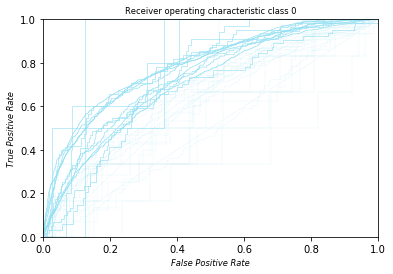

0.5483130662851693
0.6387355541497859
0.6737742760291424
0.5753258762117823
0.6200841991774059
0.6682116295198011
0.634686432750844
0.4463519313304721
0.6945717184740222
0.6412717254972228
0.4641154029566047
0.6771481450235167
0.6537051935282023
0.5120896520472519
0.6507198426182599
0.4737869575584168
0.4703743443013829
0.6685824588801006
0.5781114984654807


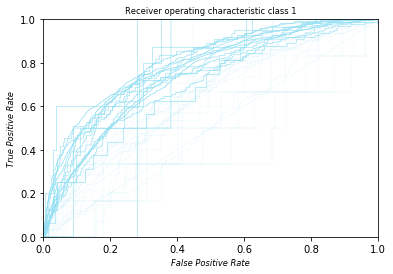

0.5418007868383405
0.649993609286784
0.6448966043785292
0.5297061894108874
0.6945262213209552
0.6355212789192672
0.6719943115179544
0.6462145719831146
0.38403075822603716
0.6887757314362196
0.6812622965480236
0.6353940026108993
0.48403969957081544
0.524924763862817
0.5489328239651022
0.6783893920619307
0.5038894849785408
0.5409960658082975
0.6723489742495057
0.65728077232502


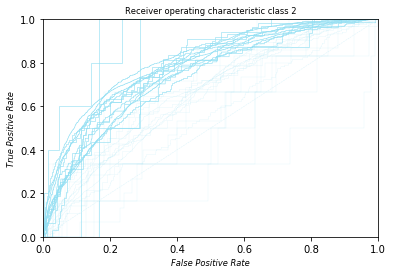

0.5831545064377681
0.6495311141252768
0.6753908121638748
0.5683340790454885
0.633561029742632
0.6786637343933256
0.6414896498053624
0.5230984740104911
0.6737784343029928
0.5880991772491504
0.5881169527896996
0.6872930419927024
0.3740949316170555
0.543158406890893
0.6849554808957473
0.5028761325703386
0.48468049594659035
0.6259978035682185
0.634933774834437
0.6675903578558445


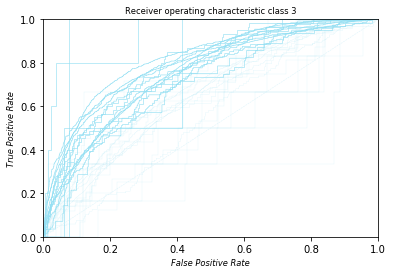

0.5660318311874106
0.6562464853294769
0.6683246237411392
0.5826935123042506
0.6291249533385888
0.670507596426581
0.6442538182738249
0.4832647830233667
0.529813539617242
0.6878103642460388
0.5608160467334287
0.4086588599862936
0.61350116778714
0.6047061228139651
0.46086671435383886
0.38285348116356704
0.6610297669872371
0.668040764274208
0.46989064688179727


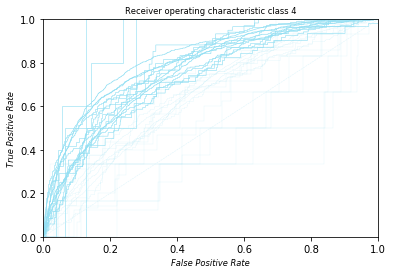

0.6265647353361945
0.665689218684973
0.6336407438752985
0.5238240119313945
0.6250091631170162
0.6793697908435298
0.6522454538882645
0.5697573915116834
0.6803232874262207
0.4559638769670959
0.44340156729537256
0.6118859249959581
0.5522919647114926
0.40149618502622797
0.687160845092576
0.6710611687846787
0.5524567205983134


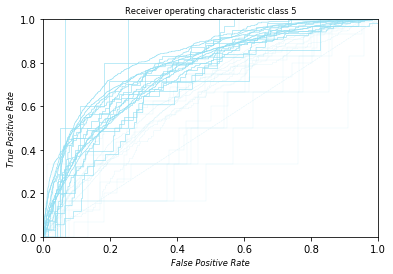

0.5219062947067239
0.6652494081161792
0.6492567180286319
0.5728560775540641
0.6299316835587554
0.6842915859126109
0.6465714398375426
0.6244784215546018
0.6735471729748012
0.686169737077446
0.6751590216807023
0.45535288507391514
0.6936296479868391
0.42111379279520866
0.5953012222864036
0.6034031246407174
0.4191553409632809
0.3836432999523128
0.6654219283659896
0.6949950778593162
0.4895861267542683


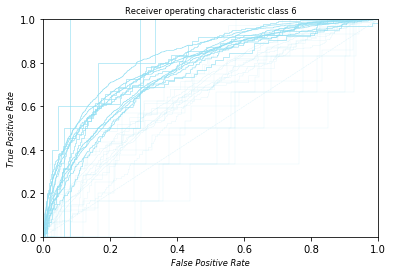

0.5930048879351455
0.6618424838648904
0.6659932965246713
0.5811066368381805
0.6236926816486921
0.6867941385032564
0.6524493881561221
0.6645654506437768
0.6981418152279804
0.6508115721695582
0.5070636623748211
0.31995470933524034
0.6286850572583835
0.6004011190454899
0.551710777300906
0.4152211492608488
0.6756099170861045
0.6800440755324861
0.42909925210810157


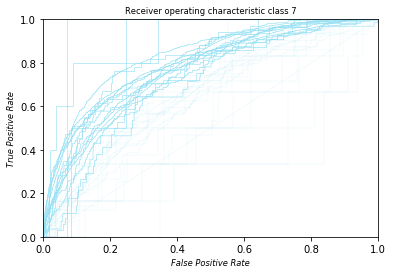

0.5395207439198856
0.6673138391005566
0.6717662000653779
0.5453005219985085
0.6327947112180236
0.6845563327122549
0.6573946743514082
0.6429870052455888
0.6717144269488826
0.5011921793037672
0.6988457806930589
0.3674801108429427
0.532906776657009
0.6792325085269734
0.5261087267525035
0.4319861707200763
0.6862409839564982
0.6993243243243243
0.5534400047674383


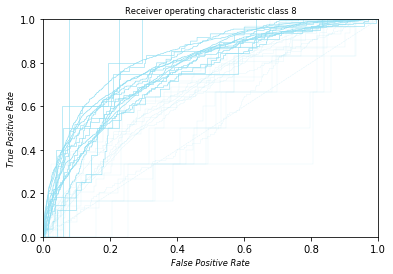

0.5791905102527419
0.6620154677434404
0.6821502617355598
0.6316301267710663
0.6303111775742533
0.6828604325575398
0.6563848608619265
0.6817164793931704
0.5603838817358131
0.31620035159858173
0.588506651870395
0.6856836269337387
0.5118174773485933
0.4514783023366714
0.6675544613967285
0.6632472704492571
0.5783498703852685


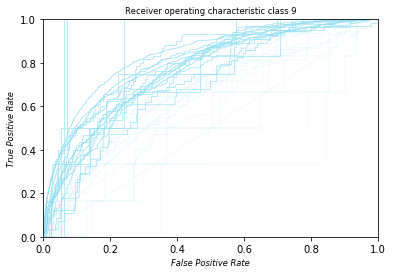

In [32]:
from scipy.io import loadmat
import numpy as np

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, matthews_corrcoef
from sklearn.metrics import f1_score, precision_score

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

import matplotlib.pyplot as plt

for f in range(10):
    filename = 'new_result_encoding_pssm/new_encoding_pssm_4802_' + str(f) + '.mat'
    result = loadmat(filename)
    test_y = result['test_y']
    pred_y = result['pred_y']

    # for i in range(37):
    #     fpr, tpr, _ = roc_curve(test_y[:, i], pred_y[:, i])
    #     roc_auc = auc(fpr, tpr)
    #     print(roc_auc)

    # plot ROC

    plt.figure()

    for i in range(37):
        fpr, tpr, _ = roc_curve(test_y[:, i], pred_y[:, i])
        roc_auc = auc(fpr, tpr)
        slw = 0.6
        if roc_auc < 0.7:
            print(roc_auc)
            slw = 0.1
        plt.plot(fpr, tpr, color='#92DFF3',
                 lw=slw, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='#DBF3FA', lw=0.5, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate', fontsize = 'small', fontstyle='italic')
    plt.ylabel('True Positive Rate', fontsize = 'small', fontstyle='italic')
    plt.title('Receiver operating characteristic class ' + str(f), fontsize = 'small')
    # plt.legend(loc="lower right")


    plt.show()

In [33]:
sequence = loadmat('dataset_3106.mat')

In [34]:
sequence.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Y_3106', 'label_name', 'protein_list', 'sequence_3106'])

In [37]:
filename = 'new_result_encoding/new_encoding_4802_res_8.mat'
result = loadmat(filename)
test_y = result['test_y']
pred_y = result['pred_y']

# for i in range(37):
#     fpr, tpr, _ = roc_curve(test_y[:, i], pred_y[:, i])
#     roc_auc = auc(fpr, tpr)
#     print(roc_auc)

# plot ROC

t = []
for i in range(37):
    fpr, tpr, _ = roc_curve(test_y[:, i], pred_y[:, i])
    roc_auc = auc(fpr, tpr)
    t.append(roc_auc)
    print(roc_auc)
    
print(np.average(t))

0.8118648353261668
0.8149055755395684
0.7102709712037203
0.8584972654724036
0.7937028911425683
0.7839285433287699
0.8158853688399144
0.7309809789459132
0.8048593895258753
0.6631439259744081
0.8161729553531665
0.8756468301701862
0.8225543413928037
0.6597321588266858
0.9121003545782306
0.8337876742665514
0.8591502683363148
0.821927624507345
0.6311673221308545
0.8060091265808711
0.8067150260493734
0.5785244922341697
0.7295196531703771
0.5530621367903442
0.8209627517592818
0.7298112160261383
0.8261949475691134
0.8638769556797596
0.8389122273864855
0.7201978717485047
0.8649903812172862
0.7154098695724378
0.5223235574630425
0.792273987302155
0.6126251723931162
0.7578867804431714
0.7929727313366115
0.7662850853941539


In [7]:
from scipy.io import loadmat
import numpy as np

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, matthews_corrcoef
from sklearn.metrics import f1_score, precision_score

for c in range(5):
    for f in range(10):
        filename = 'encoding_pssm_4802/new_encoding_pssm_4802_' +str(c) + '_' +  str(f) + '.mat'
        result = loadmat(filename)
        test_y = result['test_y']
        pred_y = result['pred_y']
        resauc = []
        for i in range(37):
            if i in [18, 31, 28]:
                continue
            if sum(test_y[:, i]) == 0:
                print(c, f, i)
            
            fpr, tpr, _ = roc_curve(test_y[:, i], pred_y[:, i])
            roc_auc = auc(fpr, tpr)
            resauc.append(roc_auc)
        print('{}, auc: {:.4f}, {:.4f}'.format(f, 
            np.amax(resauc), np.average(resauc)))

0, auc: 0.8033, 0.6762
1, auc: 0.9352, 0.7462
2, auc: 0.9058, 0.7946
3, auc: 0.9124, 0.8152
4, auc: 0.9308, 0.8300
5, auc: 0.9610, 0.8464
6, auc: 0.9590, 0.8509
7, auc: 0.9627, 0.8593
8, auc: 0.9409, 0.8658
9, auc: 0.9792, 0.8695
0, auc: 0.8137, 0.6841
1, auc: 0.8999, 0.7659
2, auc: 0.9538, 0.8091
3, auc: 0.9500, 0.8322
4, auc: 0.9719, 0.8552
5, auc: 0.9752, 0.8541
6, auc: 0.9668, 0.8717
7, auc: 0.9840, 0.8721
8, auc: 0.9796, 0.8828
9, auc: 0.9810, 0.8843
0, auc: 0.8508, 0.6738
1, auc: 0.9003, 0.7272
2, auc: 0.8770, 0.7646
3, auc: 0.9019, 0.7933
4, auc: 0.9137, 0.8016
5, auc: 0.9116, 0.8063
6, auc: 0.9382, 0.8322
7, auc: 0.9204, 0.8397
8, auc: 0.9197, 0.8319
9, auc: 0.9411, 0.8451
0, auc: 0.8224, 0.6768
1, auc: 0.8746, 0.7358
2, auc: 0.8994, 0.7893
3, auc: 0.9062, 0.8045
4, auc: 0.9320, 0.8256
5, auc: 0.9186, 0.8308
6, auc: 0.9269, 0.8506
7, auc: 0.9474, 0.8428
8, auc: 0.9445, 0.8489
9, auc: 0.9434, 0.8594
0, auc: 0.8198, 0.6583
1, auc: 0.8587, 0.6902
2, auc: 0.8968, 0.7596
3, auc: 0.9

0.7102709712037203
0.7309809789459132
0.6631439259744081
0.6597321588266858
0.5785244922341697
0.7295196531703771
0.5530621367903442
0.7298112160261383
0.7201978717485047
0.5223235574630425
0.6126251723931162
0.6444404719342153
0.6952193609918933
0.514633180465247
0.7452483203756965
0.5930048879351455
0.6618424838648904
0.6659932965246713
0.7284540151973817
0.5811066368381805
0.7297959680411901
0.6236926816486921
0.6867941385032564
0.6524493881561221
0.6645654506437768
0.6981418152279804
0.6508115721695582
0.7034341643842629
0.5070636623748211
0.7401899268133212
0.31995470933524034
0.6286850572583835
0.551710777300906
0.4152211492608488
0.6756099170861045
0.6800440755324861
0.42909925210810157
0.5068860668932212


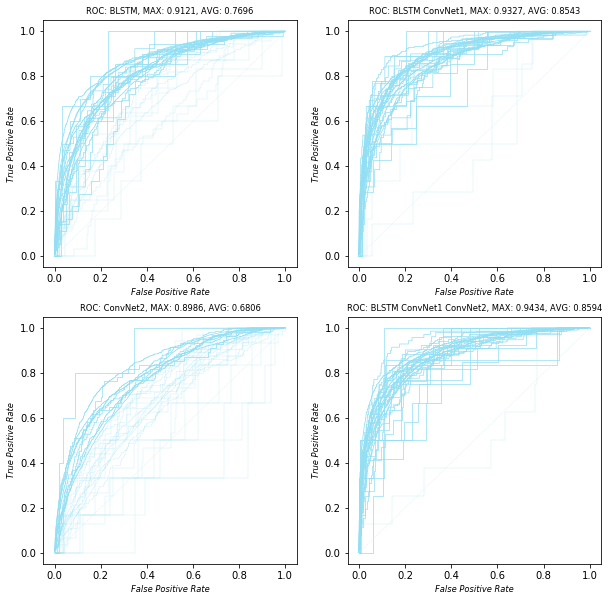

In [36]:
import matplotlib.pyplot as plt
fnames = ['new_encoding_4802_res_8.mat', 'new_encoding_4802_lrg_6.mat',  
          'new_pssm_4802_7.mat', 'new_encoding_pssm_4802_3_9.mat']
modelname = ['BLSTM', 'BLSTM ConvNet1', 'ConvNet2', 'BLSTM ConvNet1 ConvNet2']
f, axs = plt.subplots(2, 2,  figsize=(10,10))

for m in range(2):
    for n in range(2):
        filename = 'plot_auc/' + fnames[m*2 + n]
        result = loadmat(filename)
        test_y = result['test_y']
        pred_y = result['pred_y']
        fig1 = axs[m,n]
        tmp = []
        for i in range(37):
            if i in [18,31,28]:
                continue
            fpr, tpr, _ = roc_curve(test_y[:, i], pred_y[:, i])
            roc_auc = auc(fpr, tpr)
            tmp.append(roc_auc)
            slw = 0.7
            if roc_auc < 0.7:
                print(roc_auc)
                slw = 0.2
            fig1.plot(fpr, tpr, color='#92DFF3',
                     lw=slw, label='ROC curve (area = %0.4f)' % roc_auc)
        fig1.plot([0, 1], [0, 1], color='#DBF3FA', lw=0.5, linestyle='--')
        # fig1.xlim([0.0, 1.0])
        # fig1.ylim([0.0, 1.0])
        # fig1.xlabel('False Positive Rate', fontsize = 'small', fontstyle='italic')
        # fig1.ylabel()
        fig1.set_title('ROC: {}, MAX: {:.4f}, AVG: {:.4f}'.format(modelname[m*2 + n], np.amax(tmp), np.average(tmp)), fontsize = 'small')
        fig1.set_xlabel('False Positive Rate', fontsize = 'small', fontstyle='italic')
        fig1.set_ylabel('True Positive Rate', fontsize = 'small', fontstyle='italic')
plt.savefig('auc_4802.pdf')

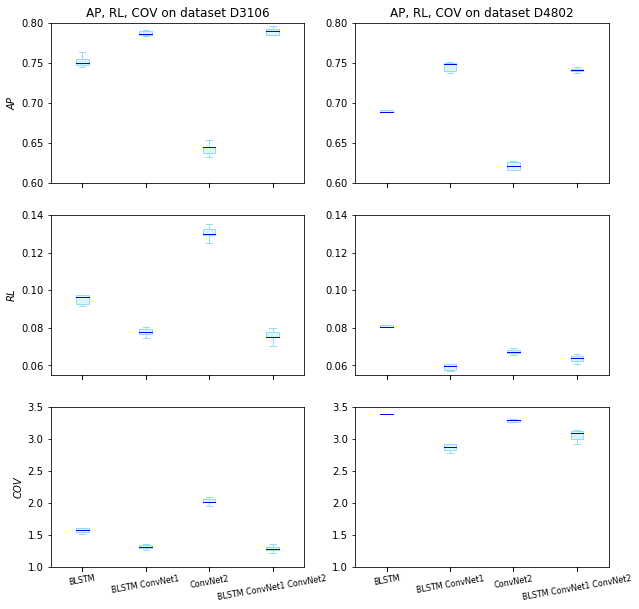

In [35]:
data = np.array([[0.7476, 0.7910, 0.6324, 0.7903], 
        [0.7640, 0.7844, 0.6536, 0.7932], 
        [0.7503, 0.7853, 0.6452, 0.7967], 
        [0.7452, 0.7867, 0.6449, 0.7853], 
        [0.7546, 0.7906, 0.6376, 0.7849]])

f, axs = plt.subplots(3, 2,  figsize=(10,10), sharex = True)
c= '#92DFF3'
axs[0,0].boxplot(data, showfliers=False, widths = 0.2 ,patch_artist=True,
            boxprops=dict(facecolor='#DBF3FA', color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color='blue'),)
axs[0,0].set_ylim(0.6,0.8)
axs[0,0].set_title('AP, RL, COV on dataset D3106')
# axs[0,0].set_xticklabels(modelname,
#                     rotation=10, fontsize=8)
axs[0,0].set_ylabel('AP',fontstyle='italic')

rl_data_3 = np.array([[0.0965, 0.0780, 0.1351, 0.0749],
                     [0.0916, 0.0804, 0.1253, 0.0751],
                     [0.0973, 0.0769, 0.1292, 0.0706],
                     [0.1052, 0.0792, 0.1301, 0.0780],
                     [0.0928, 0.0747, 0.1327, 0.0801]])

axs[1,0].boxplot(rl_data_3, showfliers=False, widths = 0.2 ,patch_artist=True,
            boxprops=dict(facecolor='#DBF3FA', color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color='blue'),)
axs[1,0].set_ylim(0.055,0.14)
# axs[1,0].set_xticklabels(modelname,
#                     rotation=10, fontsize=8)
axs[1,0].set_ylabel('RL',fontstyle='italic')

ce_data_3 = np.array([[1.5740, 1.3342, 2.0872, 1.2681],
                     [1.5097, 1.3532, 1.9539, 1.2115],
                     [1.6049, 1.2969, 2.0139, 1.3496],
                     [1.7229, 1.3087, 2.0138, 1.2824],
                     [1.5359, 1.2636, 2.0621, 1.3124]])

axs[2,0].boxplot(ce_data_3, showfliers=False, widths = 0.2 ,patch_artist=True,
            boxprops=dict(facecolor='#DBF3FA', color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color='blue'),)
axs[2,0].set_ylim(1,3.5)
axs[2,0].set_xticklabels(modelname,
                    rotation=10, fontsize=8)
axs[2,0].set_ylabel('COV',fontstyle='italic')

ap_data_4 = np.array([[0.6890, 0.7395,0.6161,0.7377],
            [0.6916,0.7372,0.6216,0.7406],
            [0.6823, 0.7514,0.6260,0.7416],
            [0.6993,0.7499,0.6161,0.7428],
            [0.6883,0.7484,0.6270,0.7445]])
axs[0,1].boxplot(ap_data_4, showfliers=False, widths = 0.2 ,patch_artist=True,
            boxprops=dict(facecolor='#DBF3FA', color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color='blue'),)
axs[0,1].set_ylim(0.6,0.8)
axs[0,1].set_title('AP, RL, COV on dataset D4802')
# axs[0,0].set_xticklabels(modelname,
#                     rotation=10, fontsize=8)
# axs[0,1].set_ylabel('AP')

rl_data_4 = np.array([[0.0805, 0.0609, 0.0692, 0.0641],
                     [0.0816, 0.0666, 0.0665, 0.0624],
                     [0.0870, 0.0571, 0.0671, 0.0649],
                     [0.0802, 0.0574, 0.0683, 0.0609],
                     [0.0806, 0.0595, 0.0655, 0.0662]])

axs[1,1].boxplot(rl_data_4, showfliers=False, widths = 0.2 ,patch_artist=True,
            boxprops=dict(facecolor='#DBF3FA', color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color='blue'),)
axs[1,1].set_ylim(0.055,0.14)

ce_data_4 = np.array([[3.4141, 2.9260, 3.3119, 3.0970],
                     [3.3900, 3.2157, 3.2634, 2.9896],
                     [3.3904, 2.7791, 3.2571, 3.1361],
                     [3.3864, 2.8273, 3.3015, 2.9197],
                     [3.3772, 2.8645, 3.3002, 3.1217]])

axs[2,1].boxplot(ce_data_4, showfliers=False, widths = 0.2 ,patch_artist=True,
            boxprops=dict(facecolor='#DBF3FA', color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color='blue'),)
axs[2,1].set_ylim(1,3.5)
axs[2,1].set_xticklabels(modelname,
                    rotation=10, fontsize=8)
plt.savefig('boxchart.pdf')